# StateAtom Objects

In PairInteraction we define `KetAtom` objects, which form the canonical basis using the atomic states defined by their quantum numbers.
Ket objects are immutable and used to span the Hilbert space of the single atom system.
In addition, we also define `StateAtom` objects, which can also represent arbitrary superpositions in the basis spanned by the `KetAtom` objects.
In this tutorial we will show how to use the `StateAtom` object to create superposition states and calculate overlaps with other states.

In [ ]:
# %pip install -q pairinteraction # Uncomment for installation on Colab

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction as pi
from pairinteraction.visualization.colormaps import alphamagma

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

## Simple example: create a superposition
As a first example, we demonstrate how to create a superposition of two or more `KetAtom` objects.
To do so, we first need to define a `BasisAtom`, in which the state will live.
Then we can create a `StateAtom` corresponding to a single `KetAtom` by passing the ket and the basis to the `StateAtom` constructor.

Finally, you can add multiple `StateAtom` objects together or multiply them by a scalar by simply using the built-in operators `+`, `-`, `*` and `/`.
If you want to calculate overlaps and expectation values, don't forget to normalize the states using the `normalize()` method.

The coefficients of a `StateAtom` can be accessed using the `get_coefficients()` method, which returns a numpy array containing the coefficients in the order of the `KetAtom` objects in the basis.

In [3]:
ket1 = pi.KetAtom("Sr88_singlet", n=60, l=59, m=58)
print(f"Ket of interest: {ket1}")
basis = pi.BasisAtom("Sr88_singlet", n=(ket1.n - 4, ket1.n + 4), l=(50, 60), m=(50, 60))
print(f"Number of basis states: {basis.number_of_states}")

state1 = pi.StateAtom(ket1, basis)
# this state only has one entry in its coefficient vector
print(f"{state1.get_coefficients().nonzero()=}")
# this can also be seen by just printing the state
print(f"State1: {state1}")

# To showcase addition, ... of two states we also define a second state
ket2 = pi.KetAtom("Sr88_singlet", n=60, l=58, m=58)
state2 = pi.StateAtom(ket2, basis)
print(f"State2: {state2}")

# now we can create a symmetric and anti-symmetric superposition of these two states
state_plus = (state1 + state2).normalize()
state_minus = (state1 - state2).normalize()
print(f"State plus: {state_plus}")
print(f"State minus: {state_minus}")

# and you can create any linear combination of as many states as you want
ket3 = pi.KetAtom("Sr88_singlet", n=60, l=57, m=57)
state3 = pi.StateAtom(ket3, basis)
print(f"{1.1 * state1 + 0.6 * state2 - 0.4 * state3 = }")

Ket of interest: |Sr88_singlet:60,59_59,58⟩
Number of basis states: 449
state1.get_coefficients().nonzero()=(array([183]),)
State1: StateAtom(1.00 |Sr88_singlet:60,59_59,58⟩)
State2: StateAtom(1.00 |Sr88_singlet:60,58_58,58⟩)
State plus: StateAtom(0.71 |Sr88_singlet:60,58_58,58⟩ + 0.71 |Sr88_singlet:60,59_59,58⟩)
State minus: StateAtom(-0.71 |Sr88_singlet:60,58_58,58⟩ + 0.71 |Sr88_singlet:60,59_59,58⟩)
1.1 * state1 + 0.6 * state2 - 0.4 * state3 = StateAtom(1.10 |Sr88_singlet:60,59_59,58⟩ + 0.60 |Sr88_singlet:60,58_58,58⟩ + -0.40 |Sr88_singlet:60,57_57,57⟩)


## Use state objects to calculate overlaps and expectation values

One can use the `StateAtom` objects to calculate overlaps and expectation values.
In PairInteraction, three kinds of objects can calculate overlaps (`get_overlap(s)`) and expectation values (`get_matrix_element(s)`):
- `BasisAtom` / `BasisPair`
  - `get_overlaps(basis)` -> returns a matrix containing all pair-wise overlaps between states of the two bases
  - `get_overlaps(state)` -> returns a vector containing the overlaps between all basis states and the given state
  - `get_overlaps(ket)` -> returns a vector containing the overlaps between all basis states and the given ket
- `StateAtom` / `StatePair`
  - `get_overlap(state)` -> returns the overlap between this state and another state
  - `get_overlap(ket)` -> returns the overlap between this state and a ket
- `KetAtom` / `KetPair`
  - `get_overlap(ket)` -> returns the overlap between this ket and another ket


In [4]:
ov = state_plus.get_overlap(ket1)
print(f"Overlap of state_plus with ket: {ov}")

d = state_plus.get_matrix_element(state_plus, "electric_dipole", q=0)
print(f"Matrix element of state_plus with state_plus: {d}")

Overlap of state_plus with ket: 0.4999999999999999
Matrix element of state_plus with state_plus: (-90.00056153827039+0j) atomic_unit_of_current * atomic_unit_of_time * bohr


## Stark map with overlap to a superposition state

For circular states with an external electric field along the z-direction, the eigenstates are superpositions of states with different l but the same m quantum number.

For the special case defined above (ket1 with n=60, l=59, m=58 and ket2 with n=60, l=58, m=58), the eigenstates are the symmetric and antisymmetric superpositions of these two kets.
This can be visualized by calculating the Stark map and the overlap of the eigenstates with these two superposition states.

Note for details on how to calculate Stark maps, see the tutorial [Stark maps](./stark_map.ipynb).

In [5]:
electric_fields = np.linspace(0, 10, 50)
systems = [
    pi.SystemAtom(basis).set_electric_field([0, 0, e], unit="V/cm") for e in electric_fields
]

# Diagonalize the systems in parallel
pi.diagonalize(systems, diagonalizer="eigen", float_type="float32")

eigenenergies = [
    system.get_eigenenergies(unit="GHz") - ket1.get_energy(unit="GHz") for system in systems
]
overlaps_plus = [system.get_eigenbasis().get_overlaps(state_plus) for system in systems]
overlaps_minus = [system.get_eigenbasis().get_overlaps(state_minus) for system in systems]

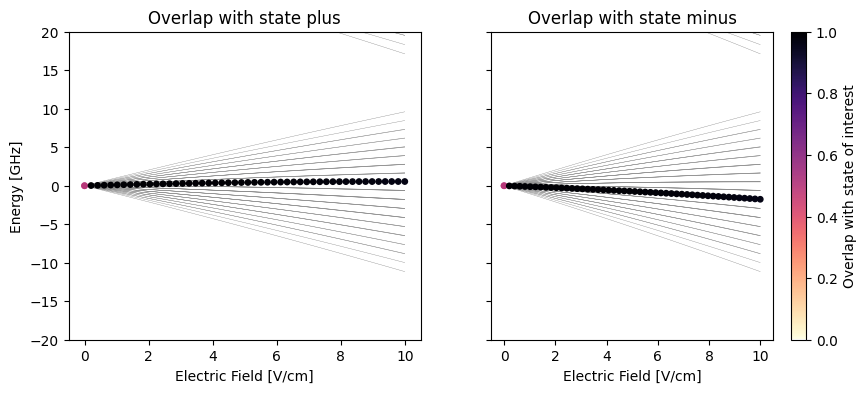

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

x_repeated = np.hstack(
    [val * np.ones_like(es) for val, es in zip(electric_fields, eigenenergies)]
)
energies_flattened = np.hstack(eigenenergies)

for i, ax in enumerate(axs):
    try:
        ax.plot(electric_fields, np.array(eigenenergies), c="0.5", lw=0.25, zorder=-10)
    except ValueError:  # inhomogeneous shape -> no simple line plot possible
        for x, es in zip(electric_fields, eigenenergies):
            ax.plot([x] * len(es), es, c="0.5", ls="None", marker=".", zorder=-10)

    if i == 0:
        ax.set_title("Overlap with state plus")
        overlaps_flattened = np.hstack(overlaps_plus)
    else:
        ax.set_title("Overlap with state minus")
        overlaps_flattened = np.hstack(overlaps_minus)

    sorter = np.argsort(overlaps_flattened)

    scat = ax.scatter(
        x_repeated[sorter],
        energies_flattened[sorter],
        c=overlaps_flattened[sorter],
        s=15,
        vmin=0,
        vmax=1,
        cmap=alphamagma,
    )

fig.colorbar(scat, ax=axs[1], label="Overlap with state of interest")

for ax in axs:
    ax.set_xlabel("Electric Field [V/cm]")
    ax.set_ylim(-20, 20)
axs[0].set_ylabel("Energy [GHz]")

plt.show()